# <img style="float: left; padding-right: 10px; width: 45px" src="fig/iacs.png"> S-109A Introduction to Data Science 
## Homework 4 - Regularization 



**Harvard University**<br/>
**Summer 2018**<br/>
**Instructors**: Pavlos Protopapas, Kevin Rader

<hr style="height:2pt">

### INSTRUCTIONS

- To submit your assignment follow the instructions given in canvas.
- Restart the kernel and run the whole notebook again before you submit. 
- If you submit individually and you have worked with someone, please include the name of your [one] partner below. 

Names of people you have worked with goes here: 

<hr style="height:2pt">

In [1]:
from IPython.core.display import HTML
def css_styling(): styles = open("cs109.css", "r").read(); return HTML(styles)
css_styling()

import these libraries

In [2]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import KFold

#import statsmodels.api as sm

from pandas.core import datetools
%matplotlib inline

# Continuing Bike Sharing Usage Data

In this homework, we will focus on regularization and cross validation. We will continue to build regression models for the Capital Bikeshare program in Washington D.C.  See homework 3 for more information about the Capital Bikeshare data that we'll be using extensively. 



## Data Preparation



<div class='exercise'> <b> Question 1 </b> </div> 
  In HW3 Questions 1-3, you preprocessed the data in preparation for your regression analysis. We ask you to repeat those steps (particularly those in Question 3) so that we can compare the analysis models in this HW with those you developed in HW3.  In this HW we'll be using models from sklearn exclusively (as opposed to statsmodels)
  
**1.1** [From HW3] Read `data/BSS_train.csv` and `data/BSS_test.csv` into dataframes `BSS_train` and `BSS_test`, respectively.  Remove the `dteday` column from both train and test dataset. We do not need it, and its format cannot be used for analysis.  Also remove the `casual` and `registered` columns for both training and test datasets as they make  `count` trivial.   

**1.2** Since we'll be exploring Regularization and Polynomial Features, it will make sense to standardize our data.  Standardize the numerical features. Store the dataframes for the processed training and test predictors into the variables `X_train` and `X_test`.  Store the appropriately shaped numpy arrays for the corresponding train and test `count` columns into `y_train` and `y_test`.

**1.3** Use the `LinearRegression` library from `sklearn` to fit a multiple linear regression model to the training set data in `X_train`.  Store the fitted model in the variable `BikeOLSModel`.

**1.4** What are the training and test set $R^2$ scores?  Store the training and test $R^2$ scores of the `BikeOLSModel` in a dictionary `BikeOLS_r2scores` using the string 'training' and 'test' as keys.  

**1.5**   We're going to use bootstrapped confidence intervals (use 500 bootstrap iterations) to determine which of the estimated coefficients for the `BikeOLSModel` are statistically significant at a significance level of 5% .  We'll do so by creating 3 different functions:

1. `make_bootstrap_sample(dataset_X, dataset_y)` returns a bootstrap sample of `dataset_X` and `dataset_y`
2. `calculate_coefficients(dataset_X, dataset_y, model)` returns in the form of a dictionary regression coefficients calculated by your model on `dataset_X` and `dataset_y`.  The keys for regression coefficients dictionary should be the names of the features.  The values should be the coefficient values of that feature calculated on your model.  An example would be {'hum': 12.3, 'windspeed': -1.2, 'Sunday': 0.6 ... }
3. `get_significant_predictors(regression_coefficients, significance_level)` takes as input a list of regression coefficient dictionaries (each one the output of `calculate_coefficients` and  returns a python list of the feature names of the significant predictors e.g. ['Monday', 'hum', 'holiday', ... ]

In the above functions `dataset_X` should always be a pandas dataframe with your features, `dataset_y` a numpy column vector with the values of the response variable and collectively they form the dataset upon which the operations take place. `model` is the `sklearn` regression model that will be used to generate the regression coefficients. `regression_coefficients` is a list of dictionaries of numpy arrays with each numpy array containing the regression coefficients (not including the intercept) calculated from one bootstrap sample.  `significance_level` represents the significance level as a floating point number.  So a 5% significance level should be represented as 0.05.  


Store the feature names as a list of strings in the variable `BikeOLS_significant_bootstrap` and print them for your answer.


### Answers

#### 1.1 Read `data/BSS_train.csv` and `data/BSS_test.csv` into Pandas DataFrames

In [3]:
# your code here

BSS_train = pd.read_csv('data/BSS_train.csv')
BSS_test = pd.read_csv('data/BSS_test.csv')

BSS_train = BSS_train.drop(['dteday','casual','registered', 'Unnamed: 0'], axis=1)
BSS_test = BSS_test.drop(['dteday','casual','registered', 'Unnamed: 0'], axis=1)

BSS_train.describe()

,hour,holiday,year,workingday,temp,atemp,hum,windspeed,counts,spring,...,Dec,Mon,Tue,Wed,Thu,Fri,Sat,Cloudy,Snow,Storm
count,13903.000000,13903.000000,13903.000000,13903.000000,13903.000000,13903.000000,13903.000000,13903.000000,13903.000000,13903.000000,...,13903.000000,13903.000000,13903.000000,13903.000000,13903.000000,13903.000000,13903.000000,13903.000000,13903.00000,13903.000000
mean,11.529454,0.029274,0.504567,0.680644,0.496732,0.475426,0.629051,0.190025,187.885492,0.253183,...,0.085305,0.140977,0.141121,0.144861,0.140833,0.142128,0.145508,0.260375,0.08286,0.000144
std,6.917884,0.168580,0.499997,0.466244,0.192699,0.171951,0.193100,0.122009,180.113476,0.434850,...,0.279346,0.348010,0.348158,0.351973,0.347862,0.349194,0.352625,0.438855,0.27568,0.011993
min,0.000000,0.000000,0.000000,0.000000,0.020000,0.000000,0.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
25%,6.000000,0.000000,0.000000,0.000000,0.340000,0.333300,0.480000,0.104500,39.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
50%,11.000000,0.000000,1.000000,1.000000,0.500000,0.484800,0.630000,0.194000,141.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
75%,18.000000,0.000000,1.000000,1.000000,0.660000,0.621200,0.780000,0.253700,280.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.00000,0.000000
max,23.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.850700,977.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000


#### 1.2 Standardizing our data

In [4]:
# your code here

# Generating training set including standardizing
X_train_orig = BSS_train.loc[:,BSS_train.columns != 'counts']
X_test_orig = BSS_test.loc[:,BSS_train.columns != 'counts']


# scaling only the continuous predictors
categorical_columns = ['hour', 'holiday', 'year', 'workingday', 'spring', 'summer',
                       'fall', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sept', 
                       'Oct', 'Nov', 'Dec', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat',
                       'Cloudy', 'Snow', 'Storm']
numerical_columns = ['temp', 'atemp', 'hum', 'windspeed']

X_train_numerical = X_train_orig[numerical_columns]
X_test_numerical = X_test_orig[numerical_columns]

scaler = StandardScaler().fit(X_train_numerical)

# create and scale the training/test set
X_train = X_train_orig.copy()
X_test = X_test_orig.copy()

X_train[numerical_columns] = scaler.transform(X_train_numerical)
X_test[numerical_columns] = scaler.transform(X_test_numerical)

y_train = BSS_train['counts'].values.reshape(-1,1)
y_test = BSS_test['counts'].values.reshape(-1,1)

#### 1.3 Use the `LinearRegression` library from `sklearn` to fit a multiple linear regression.

In [5]:
# your code here
BikeOLSModel = LinearRegression()
BikeOLSModel.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [60]:
OLS_coefficients=BikeOLSModel.coef_.ravel()

#### 1.4 What are the training and test set $R^2$ scores? Store the $R^2$ scores of the `BikeOLSModel` on the training and test sets in a dictionary `BikeOLS_r2scores`. 

In [6]:
# your code here
train_r2_score = r2_score(y_train, BikeOLSModel.predict(X_train))
test_r2_score = r2_score(y_test, BikeOLSModel.predict(X_test))
print("Train Set R^2 Score: {:.4f}".format(train_r2_score))
print("Test Set R^2 Score: {:.4f}".format(test_r2_score))

BikeOLS_r2scores = {}
BikeOLS_r2scores['training'] = train_r2_score
BikeOLS_r2scores['test'] = test_r2_score

Train Set R^2 Score: 0.4065
Test Set R^2 Score: 0.4064


#### 1.5 We're going to use bootstrapped confidence intervals to determine which of the estimated coefficients.

In [43]:
# your code here

# dataset_x should be a pandas dataframe

## accepts dataset inputs as numpy arrays
def make_bootstrap_sample(dataset_X, dataset_y, size = None):
    
    # your code here
    
    # by default return a bootstrap sample of the same size as the original dataset
    if not size: size = len(dataset_X)
    
    # if the X and y datasets aren't the same size, raise an exception
    if len(dataset_X) != len(dataset_y):
        raise Exception("Data size must match between dataset_X and dataset_y")
    
    
    sample_indices = np.random.choice(len(dataset_X), size=size, replace=True)
    
    bootstrap_dataset_X = dataset_X.iloc[sample_indices]
    bootstrap_dataset_y = dataset_y[sample_indices]
    
    # return as a tuple your bootstrap samples of dataset_X as a pandas dataframe
    # and your bootstrap samples of dataset y as a numpy column vector
    
    return (bootstrap_dataset_X, bootstrap_dataset_y)
    

def calculate_coefficients(dataset_X, dataset_y, model):
    
    # your code here
    
    # fit the model
    model.fit(dataset_X, dataset_y) 
    
    coefficients_dictionary = {k:v for k, v in zip(dataset_X.columns, model.coef_.ravel())}
    
    # return coefficients  in the variable  coefficients_dictioanry as a dictionary
    # with the key being the name of the feature as a string
    # the value being the value of the coefficients
    # do not return the intercept as part of this
    return coefficients_dictionary


def get_significant_predictors(regression_coefficients, significance_level):
    
    # your code here

    
    # regression_coefficients is a list of dictionaries
    # with the key being the name of the feature as a string
    # the value being the value of the coefficients
    # each dictionary in th list should be the output of calculate_coefficients
    
    if (len(regression_coefficients) <= 0):
        return []
    
    coeff_names = np.array(list(regression_coefficients[0].keys()), dtype='object')
    coeff_samples = [list(coeff_list.values()) for coeff_list in regression_coefficients]
    
    coeff_samples = np.array(coeff_samples)
        
    # Obtain bottom percentile values
    bottom_percentile = np.percentile(coeff_samples, q=100*significance_level/2, axis=0)
    
    # Obtain top percentile values
    top_percentile = np.percentile(coeff_samples, q=100*(1-significance_level/2), axis=0)
    
    # Coefficients with bottom value greater than 0 or top value less than 0 are signficant
    significant_index = ((bottom_percentile > 0.0) | (top_percentile < 0.0))
 
    significant_coefficients = list(coeff_names[significant_index])
      
    # return the significant coefficients as a list of strings
    return significant_coefficients

In [44]:
# Set the number of Bootstrap samplse to 500
N_bootstrap_samples = 500

In [46]:
# generate significant predictors
regression_coefficients = []
for i in range(N_bootstrap_samples):
    sample_X, sample_y = make_bootstrap_sample(X_train, y_train)
    coefficient_dict = calculate_coefficients(sample_X, sample_y, LinearRegression())
    regression_coefficients.append(coefficient_dict)
    
BikeOLS_significant_bootstrap = get_significant_predictors(regression_coefficients, 0.05)

In [78]:
# print out significant predictors
print("The statistically significant predictors in the BikeOLS model:")
print(BikeOLS_significant_bootstrap)

print("The redundant predictors in the BikeOLS model:")
print(list(set(X_train.columns) - set(BikeOLS_significant_bootstrap)))

The statistically significant predictors in the BikeOLS model:
['hour', 'year', 'temp', 'hum', 'windspeed', 'spring', 'summer', 'fall', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Nov', 'Sat', 'Cloudy', 'Snow']
The redundant predictors in the BikeOLS model:
['Sept', 'Dec', 'Oct', 'workingday', 'Storm', 'Tue', 'atemp', 'holiday', 'Mon', 'Wed', 'Feb', 'Fri', 'Thu']


## Penalization Methods

In HW 3 Question 5 we explored using subset selection to find a significant subset of features.  We then fit a regression model just on that subset of features instead of on the full dataset (including all features).   As an alternative to selecting a subset of predictors and fitting a regression model on the subset, one can fit a linear regression model on all predictors, but shrink or regularize the coefficient estimates to make sure that the model does not "overfit" the training set. 

<div class='exercise'> <b> Question 2 </b> </div> 
  We're going to use Ridge and Lasso regression regularization techniques to fit linear models to the training set.  We'll use cross-validation and shrinkage parameters $\lambda$ from the set $\{.001,.005,1,5,10,50,100,500,1000\}$ to pick the best model for each regularization technique.

**2.1** Use 5-fold cross-validation to pick the best shrinkage parameter from the set $\{.001,.005,1,5,10,50,100,500,1000\}$ for your Ridge Regression model on the training data.  Fit a Ridge Regression model on the training set with the selected shrinkage parameter and store your fitted model in the variable `BikeRRModel`.  Store the selected shrinkage parameter in the variable `BikeRR_shrinkage_parameter`.

**2.2** Use 5-fold cross-validation to pick the best shrinkage parameter from the set $\{.001,.005,1,5,10,50,100,500,1000\}$ for your Lasso Regression model on the training data.  Fit a Lasso Regression model on the training set with the selected shrinkage parameter and store your fitted model in the variable `BikeLRModel`.  Store the selected shrinkage parameter in the variable `BikeLR_shrinkage_parameter`.

**2.3** Create three dictionaries `BikeOLSparams`, `BikeLRparams`, and `BikeRRparams`.  Store in each the corresponding regression coefficients for each of the regression models indexed by the string feature name.

**2.4** For the Lasso and Ridge Regression models list the features that are assigned a coefficient value close to 0 (i.e. the absolute value of the coefficient is less than 0.1).  How closely do they match the redundant predictors found (if any) in HW 3, Question 5?

**2.5** To get a visual sense of how the features different regression models (Multiple Linear Regression, Ridge Regression, Lasso Regression) estimate coefficients, order the features by magnitude of the estimated coefficients in the Multiple Linear Regression Model (no shrinkage).  Plot a bar graph of the magnitude (absolute value) of the estimated coefficients from Multiple Linear Regression in order from greatest to least.  Using a different color (and alpha values) overlay bar graphs of the magnitude of the estimated coefficients (in the same order as the Multiple Linear Regression coefficients) from Ridge and Lasso Regression.

**2.6** Let's examine a pair of features we believe to be related.  Is there a difference in the way Ridge and Lasso regression assign coefficients to the predictors `temp` and `atemp`?

**2.7** Discuss the Results:

1. How do the estimated coefficients compare to or differ from the coefficients estimated by a plain linear regression (without shrinkage penalty) in Question 1? 
2. Is there a difference between coefficients estimated by the two shrinkage methods? If so, give an explantion for the difference.
3. Is the significance related to the shrinkage in some way?

*Hint:* You may use `sklearn`'s `RidgeCV` and `LassoCV` classes to implement Ridge and Lasso regression. These classes automatically perform cross-validation to tune the parameter $\lambda$ from a given range of values.

### Answers

In [10]:
lambdas = [.001, .005, 1, 5, 10, 50, 100, 500, 1000]

In [137]:
fold = KFold(5, shuffle=True)

#### 2.1 Use 5-fold cross-validation to pick the best shrinkage parameter from the set $\{.001,.005,1,5,10,50,100,500,1000\}$ for your Ridge Regression model.

In [155]:
# your code here

# RidgeCV
BikeRRModel = RidgeCV(cv=5, alphas=lambdas, fit_intercept=True)

BikeRRModel.fit(X_train, y_train) 

BikeRR_shrinkage_parameter = BikeRRModel.alpha_

Ridge_coefficients = BikeRRModel.coef_.ravel()

In [156]:
print("The Ridge shrinkage parameter: {}".format(BikeRR_shrinkage_parameter))

The Ridge shrinkage parameter: 500


#### 2.2 Use 5-fold cross-validation to pick the best shrinkage parameter from the set $\{.001,.005,1,5,10,50,100,500,1000\}$ for your Lasso Regression model.

In [153]:
# your code here

# Lasso
BikeLRModel = LassoCV(cv=5, alphas=lambdas, fit_intercept=True)

BikeLRModel.fit(X_train, y_train)

BikeLR_shrinkage_parameter = BikeLRModel.alpha_

Lasso_coefficients = BikeLRModel.coef_.ravel()

In [154]:
print("The Lasso shrinkage parameter: {}".format(BikeLR_shrinkage_parameter))

The Lasso shrinkage parameter: 0.005


#### 2.3 Create three dictionaries `BikeOLSparams`, `BikeLRparams`, and `BikeRRparams`.  Store in each the corresponding regression coefficients.

In [151]:
# your code here

feature_names = X_train.columns

BikeOLSparams = {k: v for k,v in zip(feature_names, BikeOLSModel.coef_.ravel())}
BikeRRparams = {k: v for k,v in zip(feature_names, BikeRRModel.coef_.ravel())}
BikeLRparams = {k: v for k,v in zip(feature_names, BikeLRModel.coef_.ravel())}   # coef_ of LassoCV is 1-D array

#### 2.4 For the Lasso and Ridge Regression models list the features that are assigned a coefficient value close to 0.  How closely do they match the redundant predictors found (if any) in HW 3, Question 5?

In [157]:
# your code here

print("Ridge predictors within 0.1 of 0:", list(feature_names[np.abs(Ridge_coefficients)<.1]))
print("----")
print("Lasso predictors within 0.1 of 0:", list(feature_names[np.abs(Lasso_coefficients)<.1]))

Ridge predictors within 0.1 of 0: []
----
Lasso predictors within 0.1 of 0: ['Mon']


<HR>
There is no resemblance between the list of statistically insignificant coefficients and the redundant predictors found in HW3, Q5 or those we found by bootstrapping in Question 1.5.  Lasso only assigned a weight very close to 0 to the coefficient for the feature 'Mon'.  If we look closely at the set of features then we should find multicollinearity between the *day of week* features ('Mon', 'Tue', 'Wed', 'Thur', 'Fri', 'Sat') and 'workingday'. Lasso finds this multi-collinearity and resolves it by assigning 'Mon' a coefficient of 0.  
<HR>

#### 2.5 To get a visual sense of how the features different regression models (Multiple Linear Regression, Ridge Regression, Lasso Regression) estimate coefficients, order the features by magnitude of the estimated coefficients in the Multiple Linear Regression Model (no shrinkage).

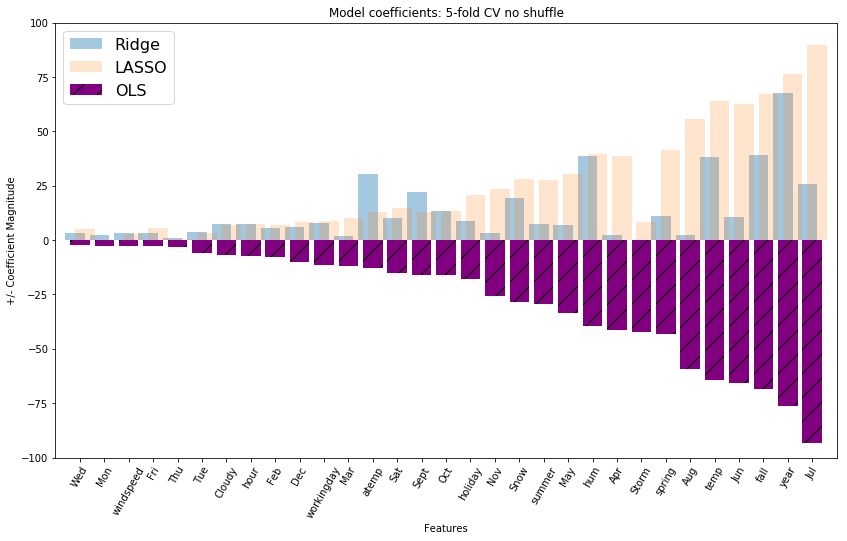

In [196]:
# your code here
si= np.argsort(np.abs(BikeOLSModel.coef_[0]))

n_coeffs = len(feature_names)

plt.figure(figsize=(14,8))
plt.bar(np.arange(n_coeffs)-0.2, np.abs(Ridge_coefficients)[si], alpha=0.4, label='Ridge')
plt.bar(np.arange(n_coeffs)+0.2, np.abs(Lasso_coefficients)[si], alpha=0.2, label='LASSO')
plt.bar(np.arange(n_coeffs), -np.abs(OLS_coefficients)[si], color='purple', hatch='/', label='OLS')
plt.xticks(range(n_coeffs), feature_names[si], rotation=60)
plt.xlim(-1,n_coeffs)
plt.ylim(-100,100)
plt.legend(fontsize=16)
plt
plt.title("Model coefficients: 5-fold CV no shuffle")
plt.xlabel("Features")
plt.ylabel("+/- Coefficient Magnitude")
plt.show()

#### 2.6 Let's examine a pair of features we believe to be related.  Is there a difference in the way Ridge and Lasso regression assign coefficients?

Recall from HW3 that `atemp` and `temp` are closely correlated.  Looking at the regression coefficients of these two predictors shows how Lasso and Ridge regression performs 'shrinkage' of the coefficient values.  First, examine the coefficient values from the ordinary linear regression:

In [66]:
print("OLS - temp: {:.4f}".format(BikOLSparams['temp']))
print("OLS - atemp: {:.4f}".format(BikOLSparams['atemp']))

OLS - temp: 64.2144
OLS - atemp: 12.8325


In contrast, examine the coefficient values of Lasso and Ridge regressions:

In [67]:
print("Lasso - temp: {:.4f}".format(BikeLRparams['temp']))
print("Lasso - atemp: {:.4f}".format(BikeLRparams['atemp']))

print("Ridge - temp: {:.4f}".format(BikeRRparams['temp']))
print("Ridge - atemp: {:.4f}".format(BikeRRparams['atemp']))

Lasso - temp: 63.8309
Lasso - atemp: 12.8684
Ridge - temp: 38.4562
Ridge - atemp: 30.3841


Observe that Lasso regression assigns similar coefficient values to the two predictors.  On the other hand, Ridge regression shrinks the value of `temp` such that two coefficient values are closer.

#### 2.7.1 How do the estimated coefficients compare to or differ from the coefficients estimated by a plain linear regression (without shrinkage penalty) in Question 1?

The shrinkage that we see from Lasso and Ridge for temp/atemp (but also for all the predictors in general) is related to how our cross-validations in Questions 2.1 and 2.2 selected the shrinkage parameter for Lasso and Ridge.  Our selected shrinkage parameter for Ridge was **500**.  Our selected shrinkage parameter for Lasso was **0.005**.  A very low shrinkage parameter for either model will mean that very little shrinkage will occur.  A high shrinkage parameter means that quite a bit of shrinkage will occur.  We should expect a lot of shrinkage in our Ridge model and very little in our Lasso model.

As a consequence, we see some noticeable differences in the plot from Question 2.5 as pertains to the regression coefficients of plain linear regression and those from Lasso and Ridge regressions.  As expected, we see general shrinkage for the Ridge coefficients in comparison to the corresponding OLS coefficients.  In particular Ridge regression places noticeably smaller estimated coefficient values on month predictors (e.g. 'Jul', 'Jun', 'Aug', etc.).  On the other hand, Lasso as expected closely follows the plain linear regression with the exception of 'storm' predictor (and 'Mon' which we discussed in question 2.4).

<HR>

#### 2.7.2 Is there a difference between coefficients estimated by the two shrinkage methods? If so, give an explantion for the difference.

<HR>

A large part of the differences between the coefficients estimated by the two regularization models is related to shrinkage parameter selection as we discussed in 2.7.1.  Our Lasso model with a low shrinkage parameter generally generated coefficients similar to those of the OLS model whereas the Ridge model generated smaller coefficients in keeping with the high shrinkage parameter. Interestingly, some exceptions to the shrinking of coefficient variables in the Ridge model include 'year', 'hum', and 'atemp'.  Coefficient values on predictors related to months as well as 'Storm' and 'Thu' saw the most aggressive shrinkage.  As aforementioned, Lasso closely follows the coefficient estimates of the plain linear regression with exception of 'Storm' and 'Mon' predictors.

Recall from Lab 4 that the penalty function of Ridge regression is
$$\lambda \sum_{j=1}^m \beta_{j}^{2}$$
while it is 
$$\lambda \sum_{j=1}^m |\beta_j|$$
for Lasso regression.

These differences in the penalty function has implications on how the coefficients of Lasso and Ridge regression are estimated, which can be visually explained with geometric interpretation.  

![Lasso (L1 Norm) vs Ridge (L2 Norm)](fig/L1_and_L2_balls.svg)

Lasso regression can be interpreted as optimization of coefficient values over a cross-polytope (i.e. a diamond in 2-dimenions) and Ridge regression as optimization over a n-sphere (i.e. a circle in 2-dimension).  The differenes in constraint boundaries explain why Lasso and Ridge regression assign different coefficient values to predictors that exhibit high collinearity.

<HR>

#### 2.7.3 Is the significance related to the shrinkage in some way?

<HR>

As visible from the geometric interpretation of the penalty function, optimization over a cross-polytope induces sparcity in estimated coefficient values.  As a result, we find that the predictor 'Mon' is assigned a coefficient value of 0 in Lasso regression as described in Question 2.4.  On the other hand, Ridge regression does not induce sparsity in coefficient estimate. 

We don't see a connection between statistical significance in the OLS model and shrinkage in the Ridge and Lasso models.  Some features that were not found to be significant (like 'Storm' and 'Thu') experienced heavy shrinkage. Other features ('atemp', 'Sep', 'Oct') did not experience much if any shrinkage.

<HR>

#### **Note**

We've described our Ridge and Lasso models based upon shrinkage parameters selected via 5 fold cross-validation.  Is this the last word in shrinkage parameter selection or are there circumstances in which we can expect to select some other paramters.  First of all let's take a closer look to see if our 5 fold cross validation did in fact select the best parameters.

In [103]:
lambda_r2s_ridge_test = []
lambda_r2s_ridge_train = []

for l in lambdas:
    ridge_model = Ridge(alpha=l).fit(X_train, y_train)
    lambda_r2s_ridge_train.append(ridge_model.score(X_train, y_train))
    lambda_r2s_ridge_test.append(ridge_model.score(X_test, y_test))

In [106]:
lambda_r2s_lasso_test = []
lambda_r2s_lasso_train = []

for l in lambdas:
    lasso_model = Lasso(alpha=l).fit(X_train, y_train)
    lambda_r2s_lasso_train.append(lasso_model.score(X_train, y_train))
    lambda_r2s_lasso_test.append(lasso_model.score(X_test, y_test))

In [112]:
shrinkage_parameters = pd.DataFrame(
    {
        'Lasso Train Scores': lambda_r2s_lasso_train,
        'Lasso Test Scores': lambda_r2s_lasso_test,
        'Ridge Train Scores': lambda_r2s_ridge_train,
        'Ridge Test Scores': lambda_r2s_ridge_test
    },index = lambdas
)

In [113]:
shrinkage_parameters

,Lasso Train Scores,Lasso Test Scores,Ridge Train Scores,Ridge Test Scores
0.001,0.406538,0.406384,0.406539,0.406386
0.005,0.406528,0.406366,0.406539,0.406386
1.000,0.400619,0.399107,0.406536,0.406388
5.000,0.381591,0.376652,0.406499,0.406383
10.000,0.357816,0.349774,0.406428,0.406350
50.000,0.203758,0.199128,0.405895,0.405969
100.000,0.148926,0.145301,0.405479,0.405561
500.000,0.000000,-0.001793,0.402667,0.401680
1000.000,0.000000,-0.001793,0.398430,0.396067


Based on performance of the Lasso and Ridge models with the different parameters it seems that our 5 fold cross validation didn't choose the appropriate shrinkage parameter.  While **0.005** was a good choice for shrinkage parameter for Lasso encouraging shrinkage with negligible impact on $R^2$ **500** as a shrinkage parameter for Ridge was totally off.  What's going on?

Well passing in cv=5 to LassoCV() and RidgeCV() is the same thing as using KFold(5, shuffle=False).  We're constructing our folds without shuffling whereas our test set was constructed with shuffling and since our rows have some order/time dependence we're failing one of the fundamental assumptions of k-fold cross-validation -- that the data is identically distributed.  We can attempt to fix this by shuffling our data before constructing the folds.  What happens in that case?

In [160]:
folds = KFold(5, shuffle=True)

In [161]:
# RidgeCV
NewRRModel = RidgeCV(cv=folds, alphas=lambdas, fit_intercept=True)

NewRRModel.fit(X_train, y_train) 

NewRR_shrinkage_parameter = NewRRModel.alpha_

Ridge_coefficients2 = NewRRModel.coef_.ravel()

In [162]:
print("The Ridge shrinkage parameter: {}".format(NewRR_shrinkage_parameter))

The Ridge shrinkage parameter: 1


In [163]:
# LassoCV
NewLRModel = LassoCV(cv=folds, alphas=lambdas, fit_intercept=True)

NewLRModel.fit(X_train, y_train) 

NewLR_shrinkage_parameter = NewLRModel.alpha_

Lasso_coefficients2 = NewLRModel.coef_.ravel()

In [164]:
print("The Lasso shrinkage parameter: {}".format(NewLR_shrinkage_parameter))

The Lasso shrinkage parameter: 0.001


In [165]:
# your code here

print("Ridge predictors within 0.1 of 0:", list(feature_names[np.abs(Ridge_coefficients2)<.1]))
print("----")
print("Lasso predictors within 0.1 of 0:", list(feature_names[np.abs(Lasso_coefficients2)<.1]))

Ridge predictors within 0.1 of 0: []
----
Lasso predictors within 0.1 of 0: []


By doing *the right thing* and incorporating shuffling, we see that we're now picking a much better shrinkage coefficient of **1.0** for Ridge (although if we're again willing to take a negligible hit to $R^2$ a coefficient of 10 would be a better choice if taking into consideration both shrinkage and $R^2$.  Our new choice of shrinkage for our Lasso model **0.001** however has the suboptimal effect of removing the sparsification we achieved on the days of the week and workingday predictors since the Lasso regression coefficient for 'Mon' is no longer set to 0.

What does our new graph look like?

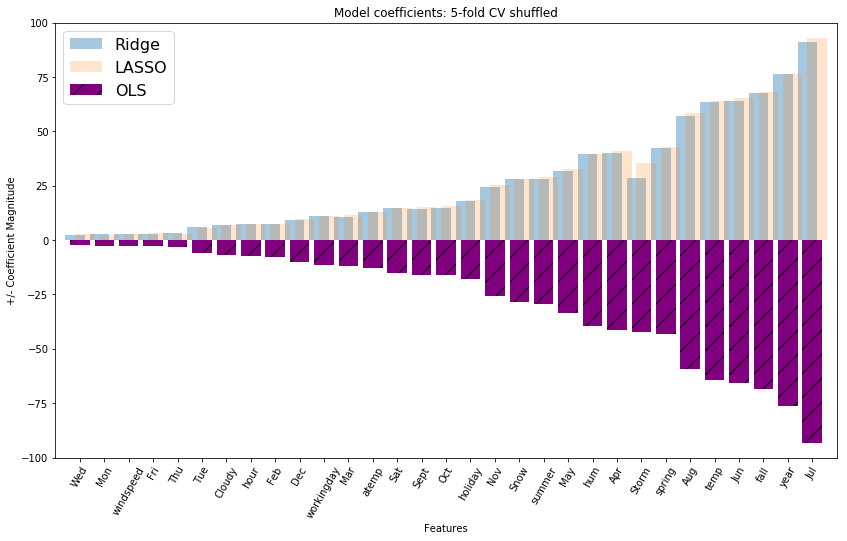

In [197]:
# your code here
si= np.argsort(np.abs(BikeOLSModel.coef_[0]))

n_coeffs = len(feature_names)

plt.figure(figsize=(14,8))
plt.bar(np.arange(n_coeffs)-0.2, np.abs(Ridge_coefficients2)[si], alpha=0.4, label='Ridge')
plt.bar(np.arange(n_coeffs)+0.2, np.abs(Lasso_coefficients2)[si], alpha=0.2, label='LASSO')
plt.bar(np.arange(n_coeffs), -np.abs(OLS_coefficients)[si], color='purple', hatch='/', label='OLS')
plt.xticks(range(n_coeffs), feature_names[si], rotation=60)
plt.xlim(-1,n_coeffs)
plt.ylim(-100,100)
plt.legend(fontsize=16)
plt.title("Model coefficients: 5-fold CV shuffled")
plt.xlabel("Features")
plt.ylabel("+/- Coefficient Magnitude")
plt.show()

We see much less of a difference between the Lasso model and the Ridge model in this case and much less shrinkage from the Ridge model compared to the model selected from 5-fold CV without shuffling.  Lasso doesn't 'sparsify' any predictor coefficients and both models are very similar to OLS (with the exception of the coefficients on the 'Storm' predictor').

What would our models look like if we used an "ideal" selection of shrinkage parameters based upon test set performance where an "ideal" selection is one that takes into account both $R^2$ performance and maximizing shrinkage (since in the case of at Least Lasso we see sparsifying coefficients as a good objective).  We can create a quantitative algorithm for choosing the "ideal" parameter by something along the lines of the highest lambda with an $R^2$ score within one standard deviation of the max $R^2$ score (sometimes called the one standard error rule).  Let's call our rule the 1% rule and state that we'd be willing to take an up to 1% hit in R^2 performance to get better shrinkage.

In [186]:
print("Max test set R^2 score for Lasso:  {:.5}".format(np.max(shrinkage_parameters['Lasso Test Scores'])))
print("1% max test set R^2 {:.5}".format(0.01*np.max(shrinkage_parameters['Lasso Test Scores'])))
#print("Standard deviation for Lasso test set R^2 scores:  {:.5}".format(np.std(shrinkage_parameters['Lasso Test Scores'])))
lasso_stds = np.std(shrinkage_parameters['Lasso Test Scores'])

pct_lst = shrinkage_parameters['Lasso Test Scores'] > np.max(shrinkage_parameters['Lasso Test Scores']) - 0.01*np.max(shrinkage_parameters['Lasso Test Scores'])
std_lst = shrinkage_parameters['Lasso Test Scores'] > np.max(shrinkage_parameters['Lasso Test Scores']) - lasso_stds
max_pct_lst = max(np.array(lambdas)[pct_lst])
max_std_lst = max(np.array(lambdas)[std_lst])


print("Max test set R^2 score for Ridge:  {:.5}".format(np.max(shrinkage_parameters['Ridge Test Scores'])))
print("1% max test set R^2 {:.5}".format(0.01*np.max(shrinkage_parameters['Ridge Test Scores'])))
#print("Standard deviation for Ridge test set R^2 scores:  {:.5}".format(np.std(shrinkage_parameters['Ridge Test Scores'])))
ridge_stds = np.std(shrinkage_parameters['Ridge Test Scores'])

pct_rst = shrinkage_parameters['Ridge Test Scores'] > np.max(shrinkage_parameters['Ridge Test Scores']) - 0.01*np.max(shrinkage_parameters['Ridge Test Scores'])
std_rst = shrinkage_parameters['Ridge Test Scores'] > np.max(shrinkage_parameters['Ridge Test Scores']) - ridge_stds

max_pct_rst = max(np.array(lambdas)[pct_rst])
max_std_rst = max(np.array(lambdas)[std_rst])


print('"Ideal" Lasso alpha 1% rule: {}'.format(max_pct_lst))
print('"Ideal" Ridge alpha 1% rule: {}'.format(max_pct_rst))

#print('"Ideal" Lasso alpha 1 standard error rule: {}'.format(max_std_lst))
#print('"Ideal" Ridge alpha 1 standard error rule: {}'.format(max_std_rst))

Max test set R^2 score for Lasso:  0.40638
1% max test set R^2 0.0040638
Max test set R^2 score for Ridge:  0.40639
1% max test set R^2 0.0040639
"Ideal" Lasso alpha 1% rule: 0.005
"Ideal" Ridge alpha 1% rule: 100.0


Based on an "ideal" selection of shrinkage parameters based upon test set performance based on the 1% rule we'd have a Lasso shrinkage parameter of **0.005** and a Ridge shrinkage parameter of **100.0**.  In other words, k-fold without shuffling seems like it came closer to picking the right shrinkage parameters than k-fold with shuffling.  But some other cross-validation strategy is probably the right way to go.  How do these shrinkage parameters affect our regularization models?

In [188]:
# RidgeCV
RRModel3 = Ridge(alpha=100, fit_intercept=True)

RRModel3.fit(X_train, y_train) 

RR_shrinkage_parameter3 = 100

Ridge_coefficients3 = RRModel3.coef_.ravel()

In [189]:
print("The Ridge shrinkage parameter: {}".format(RR_shrinkage_parameter3))

The Ridge shrinkage parameter: 100


In [190]:
# LassoCV
LRModel3 = Lasso(alpha=0.005, fit_intercept=True)

LRModel3.fit(X_train, y_train) 

LR_shrinkage_parameter3 = 0.005

Lasso_coefficients3 = LRModel3.coef_.ravel()

In [191]:
print("The Lasso shrinkage parameter: {}".format(LR_shrinkage_parameter3))

The Lasso shrinkage parameter: 0.005


In [193]:
# your code here

print("Ridge predictors within 0.1 of 0:", list(feature_names[np.abs(Ridge_coefficients3)<.1]))
print("----")
print("Lasso predictors within 0.1 of 0:", list(feature_names[np.abs(Lasso_coefficients3)<.1]))

Ridge predictors within 0.1 of 0: []
----
Lasso predictors within 0.1 of 0: ['Mon']


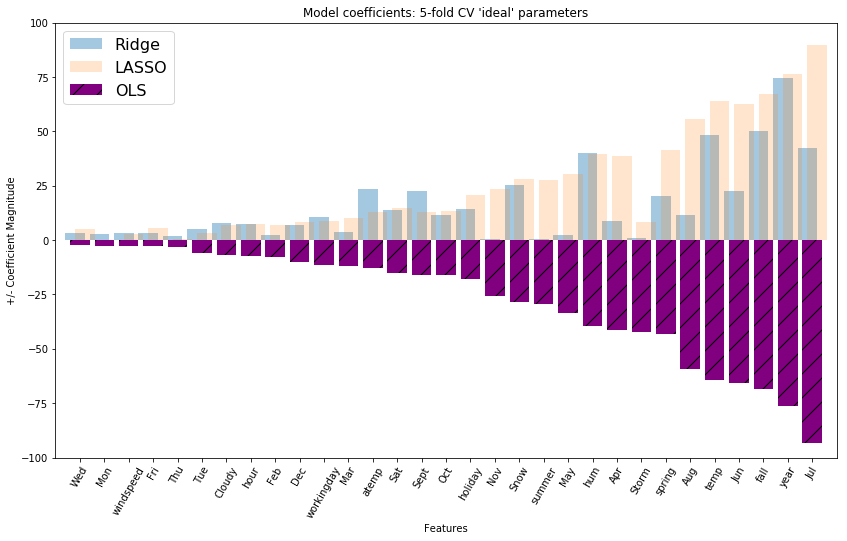

In [198]:
# your code here
si= np.argsort(np.abs(BikeOLSModel.coef_[0]))

n_coeffs = len(feature_names)

plt.figure(figsize=(14,8))
plt.bar(np.arange(n_coeffs)-0.2, np.abs(Ridge_coefficients3)[si], alpha=0.4, label='Ridge')
plt.bar(np.arange(n_coeffs)+0.2, np.abs(Lasso_coefficients3)[si], alpha=0.2, label='LASSO')
plt.bar(np.arange(n_coeffs), -np.abs(OLS_coefficients)[si], color='purple', hatch='/', label='OLS')
plt.xticks(range(n_coeffs), feature_names[si], rotation=60)
plt.xlim(-1,n_coeffs)
plt.ylim(-100,100)
plt.legend(fontsize=16)
plt.title("Model coefficients: 5-fold CV 'ideal' parameters")
plt.xlabel("Features")
plt.ylabel("+/- Coefficient Magnitude")
plt.show()

Our regularization models under parameter values selected in an "ideal" fashion look and act a lot more like the models with parameters selected without any shuffling in the 5-fold CV.  We know however that our data isn't identically distributed and in fact seems to have a time-series like nature which would suggest that something like shuffling should be a better strategy for CV.  In fact we probably in practice would use different cross-validation (as well as test set selection) strategies than we're leveredging in this homework (or homework 3 as well) based upon the nature of our data.

#### More on the one standard error rule can be found in the resources below:

Page 80 in Classification and Regression Trees by Breiman, Friedman, Stone & Olshen (1984)
Page 415 in Estimating the Number of Clusters in a Data Set via the Gap Statistic by Tibshirani, Walther & Hastie (JRSS B, 2001) (referencing Breiman et al.)
Pages 61 and 244 in Elements of Statistical Learning by Hastie, Tibshirani & Friedman (2009)
Page 13 in Statistical Learning with Sparsity by Hastie, Tibshirani & Wainwright (2015)

https://stats.stackexchange.com/questions/80268/empirical-justification-for-the-one-standard-error-rule-when-using-cross-validat
https://stats.stackexchange.com/questions/138569/why-is-lambda-within-one-standard-error-from-the-minimum-is-a-recommended-valu

<div class='exercise'> <b> Question 3: Polynomial Features, Interaction Terms, and Cross Validation </b> </div>


We would like to fit a model to include all main effects and polynomial terms for numerical predictors up to the $4^{th}$ order. More precisely use the following terms: 
 - predictors in `X_train` and `X_test`
 - $X^1_j$, $X^2_j$, $X^3_j$, and $X^4_j$ for each numerical predictor $X_j$

**3.1** Create an expanded training set including all the desired terms mentioned above. Store that training set (as a pandas dataframe) in the variable `X_train_poly`.  Create the corresponding test set and store it as a pandas dataframe in `X_test_poly`.

**3.2** Discuss the following:

1. What are the dimensions of this 'design matrix' of all the predictor variables in 3.1?  
2. What issues may we run into attempting to fit a regression model using all of these predictors?

**3.3** Let's try fitting a regression model on all the predictors anyway.  Use the `LinearRegression` library from `sklearn` to fit a multiple linear regression model to the training set data in `X_train_poly`.  Store the fitted model in the variable `BikeOLSPolyModel`.

**3.4** Discuss the following:
1. What are the training and test $R^2$ scores? 
2. How does the model performance compare with the OLS model on the original set of features in Question 1?

**3.5** The training set $R^2$ score we generated for our model with polynomial and interaction terms doesn't have any error bars.  Let's use cross-validation to generate sample sets of $R^2$ for our model. Use 5-fold cross-validation to generate $R^2$ scores for the multiple linear regression model with polynomial terms.  What are the mean and standard deviation of the $R^2$ scores for your model.

**3.6** Visualize the $R^2$ scores generated from the 5-fold cross validation as a box and whisker plot.

**3.7** We've used cross-validation to generate error bars around our $R^2$ scores, but another use of cross-validation is as a way of model selection.  Let's construct the following model alternatives:

1. Multiple linear regression model generated based upon the feature set in Question 1 (let's call these the base features.
2. base features plus polynomial features to order 2
3. base features plus polynomial features to order 4

Use 5-fold cross validation on the training set to select the best model.  Make sure to evaluate all the models as much as possible on the same folds.  For each model generate a mean and standard deviation for the $R^2$ score.

**3.8** Visualize the $R^2$ scores generated for each model from 5-fold cross validation in box and whiskers plots.  Do the box and whisker plots influence your view of which model was best?

**3.9** Evaluate each of the model alternatives on the test set.  How do the results compare with the results from cross-validation?

### Answers

#### 3.1 Create an expanded training set including all the desired terms mentioned above. Store that training set (as a numpy array) in the variable `X_train_poly`.

In [82]:
# your code here

# Create dataframe of higher order polynomials on a feature column up to order k
def gen_df_higher_orders(df, column, k):
    
    poly_model = PolynomialFeatures(k, include_bias=False)
    
    feature_data = df[column]
    
    
    # transform to get all the polynomial features of this column
    higher_orders = poly_model.fit_transform(feature_data.values.reshape(-1,1))
    
    feature_names = poly_model.get_feature_names([column])

    return pd.DataFrame(higher_orders[:,1:], columns=feature_names[1:])

def gen_df_interactions(df, categorical, numerical):
    
    poly_model= PolynomialFeatures(2, include_bias=False, interaction_only=True)
    
    all_interactions = pd.DataFrame(poly_model.fit_transform(df), columns = poly_model.get_feature_names(df.columns))
    
    
    # Generate the column names from interacations between categorical columns
    # including the categorical columns themselves and drop them
    poly_model.fit_transform(X_train[categorical])

    all_interactions = all_interactions.drop(poly_model.get_feature_names(categorical), axis=1)
    
    
    # Generate the column names from interactions between numerical columns
    # including the numerical columns themselves and drop them
    poly_model.fit_transform(X_train[numerical])

    all_interactions = all_interactions.drop(poly_model.get_feature_names(numerical), axis=1)
    
    return all_interactions

In [83]:
def get_poly_dataset(dataset_train, dataset_test, k):
    
    higher_orders_train =[gen_df_higher_orders(dataset_train, feature, k) for feature in numerical_columns]
    higher_orders_test = [gen_df_higher_orders(dataset_test, feature, k) for feature in numerical_columns]

    higher_orders_train = pd.concat(higher_orders_train, axis=1)
    higher_orders_test = pd.concat(higher_orders_test, axis=1)

    higher_orders_columns = higher_orders_train.columns

    # scale higher order polynomial features
    scaler = StandardScaler().fit(higher_orders_train)

    higher_orders_train[higher_orders_columns] = scaler.transform(higher_orders_train)
    higher_orders_test[higher_orders_columns] = scaler.transform(higher_orders_test)

    # concatenate to get the full data frames
    poly_train = pd.concat([dataset_train.reset_index().drop(['index'], axis=1)] + [higher_orders_train], axis=1)
    poly_test = pd.concat([dataset_test.reset_index().drop(['index'], axis=1)] + [higher_orders_test], axis=1)
    
    return (poly_train, poly_test)

In [84]:
X_poly_train, X_poly_test = get_poly_dataset(X_train, X_test, 4)

#### 3.2.1 What are the dimensions of this 'design matrix'?

In [85]:
X_poly_train.columns

Index(['hour', 'holiday', 'year', 'workingday', 'temp', 'atemp', 'hum',
       'windspeed', 'spring', 'summer', 'fall', 'Feb', 'Mar', 'Apr', 'May',
       'Jun', 'Jul', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec', 'Mon', 'Tue', 'Wed',
       'Thu', 'Fri', 'Sat', 'Cloudy', 'Snow', 'Storm', 'temp^2', 'temp^3',
       'temp^4', 'atemp^2', 'atemp^3', 'atemp^4', 'hum^2', 'hum^3', 'hum^4',
       'windspeed^2', 'windspeed^3', 'windspeed^4'],
      dtype='object')

In [86]:
X_poly_train.describe()

,hour,holiday,year,workingday,temp,atemp,hum,windspeed,spring,summer,...,temp^4,atemp^2,atemp^3,atemp^4,hum^2,hum^3,hum^4,windspeed^2,windspeed^3,windspeed^4
count,13903.000000,13903.000000,13903.000000,13903.000000,1.390300e+04,1.390300e+04,1.390300e+04,1.390300e+04,13903.000000,13903.000000,...,1.390300e+04,1.390300e+04,1.390300e+04,1.390300e+04,1.390300e+04,1.390300e+04,1.390300e+04,1.390300e+04,1.390300e+04,1.390300e+04
mean,11.529454,0.029274,0.504567,0.680644,-2.289600e-16,4.088572e-16,-4.783629e-16,2.289600e-16,0.253183,0.258865,...,2.453143e-17,-8.177144e-17,4.906287e-17,4.088572e-17,-1.512772e-16,1.635429e-17,1.635429e-17,-6.746144e-17,1.022143e-17,-2.657572e-17
std,6.917884,0.168580,0.499997,0.466244,1.000036e+00,1.000036e+00,1.000036e+00,1.000036e+00,0.434850,0.438027,...,1.000036e+00,1.000036e+00,1.000036e+00,1.000036e+00,1.000036e+00,1.000036e+00,1.000036e+00,1.000036e+00,1.000036e+00,1.000036e+00
min,0.000000,0.000000,0.000000,0.000000,-2.474055e+00,-2.764988e+00,-3.257769e+00,-1.557515e+00,0.000000,0.000000,...,-5.147625e-01,-9.304302e-01,-8.220754e+00,-4.712201e-01,-9.190551e-01,-1.281820e+01,-3.909072e-01,-6.197134e-01,-8.102365e-01,-1.785218e-01
25%,6.000000,0.000000,0.000000,0.000000,-8.133773e-01,-8.265766e-01,-7.719159e-01,-7.009933e-01,0.000000,0.000000,...,-5.060281e-01,-7.928673e-01,-1.881868e-01,-4.663738e-01,-7.650356e-01,-1.273693e-01,-3.858789e-01,-5.725461e-01,-1.709233e-01,-1.782270e-01
50%,11.000000,0.000000,1.000000,1.000000,1.696154e-02,5.451955e-02,4.913269e-03,3.258315e-02,0.000000,0.000000,...,-4.051289e-01,-2.619651e-01,3.236408e-02,-3.581280e-01,-3.574097e-01,4.373286e-02,-3.240565e-01,-3.155264e-01,-1.067849e-01,-1.665422e-01
75%,18.000000,0.000000,1.000000,1.000000,8.473004e-01,8.477969e-01,7.817424e-01,5.219073e-01,1.000000,1.000000,...,5.585169e-02,4.103700e-01,2.702095e-01,-1.693190e-02,5.120220e-01,2.214529e-01,4.308982e-02,1.776485e-01,-8.032379e-02,-9.642754e-02
max,23.000000,1.000000,1.000000,1.000000,2.611770e+00,3.050828e+00,1.921092e+00,5.415149e+00,1.000000,1.000000,...,1.114033e+01,7.738178e+00,1.111864e+01,1.849309e+01,8.835145e+00,2.681217e+00,1.977104e+01,1.757132e+01,2.945729e+01,4.248249e+01


<HR>
13903 x 43
<HR>

#### 3.2.2 What issues may we run into attempting to fit a regression model using all of these predictors?

<HR>
Overfitting may be a problem when applying a trained regression models using polynomial features.
<HR>

#### 3.3 Let's try fitting a regression model on all the predictors anyway.  Use the `LinearRegression` library from `sklearn` to fit a multiple linear regression model.

In [87]:
# your code here

BikeOLSPolyModel = LinearRegression()

BikeOLSPolyModel.fit(X_poly_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

#### 3.4.1 What are the training and test $R^2$ scores?

In [88]:
# your code here

BikeOLSPoly_r2scores = {}

BikeOLSPoly_r2scores['training'] = BikeOLSPolyModel.score(X_poly_train, y_train)
BikeOLSPoly_r2scores['test'] = BikeOLSPolyModel.score(X_poly_test, y_test)

print(BikeOLSPoly_r2scores)

{'training': 0.42230805166587104, 'test': 0.42027912762252395}


<HR>
Training: 0.422
    
Test: 0.420
<HR>

#### 3.4.2 How does the model performance compare with the OLS model on the original set of features in Question 1?

As a reminder, the original linear model from question 1 is

In [89]:
print(BikeOLS_r2scores)

{'training': 0.4065387827969087, 'test': 0.40638554757102285}


We see that the polynomial regression models performs slightly better in terms of $R^2$.

#### 3.5 The training set $R^2$ score we generated for our model with polynomial and interaction terms doesn't have any error bars.  Let's use cross-validation to generate sample.

First let's try to use the same cross-validation strategy (5-fold no shuffling) that we used in Question 2 (see the Note to Question 2 for further discussion)

In [212]:
# your code here

MLR_scores_orig = cross_val_score(LinearRegression(), X_poly_train, y_train, cv=5)
    
print("Mean: ", np.mean(MLR_scores_orig))
print("Std. Dev: ", np.std(MLR_scores_orig))

Mean:  0.26727805322296905
Std. Dev:  0.09109366555046743


If we use our cross-validation strategy from Question 2 (see the Note in Question 2 for additional information) we don't obtain appropriate error bars because our model's $R^2$ score isn't in the range of the $R^2$ scores we're receiving from the validation sets of our 5-fold CV without shuffling.  Since we're not using CV for model selection, let's use 5-fold CV with shuffling (the CV strategy that is most aligned with the process by which we generated our test set).  We defined the variable `folds` before to hold a sklearn 5-fold CV object with shuffling.  Let's use it here.

In [213]:
# your code here

MLR_scores = cross_val_score(LinearRegression(), X_poly_train, y_train, cv=folds)
    
print("Mean: ", np.mean(MLR_scores))
print("Std. Dev: ", np.std(MLR_scores))

Mean:  0.41809773174789927
Std. Dev:  0.013651344365428789


Much better.  Our 5-fold CV now provides appropriate error bars and a mean score very close to the $R^2$ scores we saw for our model.

#### 3.6 Plot the $R^2$ scores generated from k-fold cross validation (for each k) as a box and whisker plot.

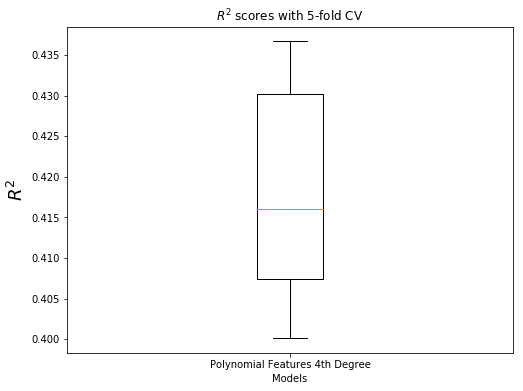

In [214]:
plt.figure(figsize=(8,6))
plt.boxplot(MLR_scores)
plt.ylabel(r"$R^2$", fontsize=18)
plt.xlabel('Models')
plt.title(r"$R^2$ scores with 5-fold CV")
plt.xticks([1],['Polynomial Features 4th Degree'])
plt.show()

#### 3.7 We've used cross-validation to generate error bars around our $R^2$ scores, but another use of cross-validation is as a way of model selection.  Let's construct the following model alternatives.

In [215]:
k_fold = KFold(n_splits=5, shuffle=True)

kfold_ks = list(range(5))

x_kfold_scores = []
poly2_kfold_scores = []
poly4_kfold_scores = []

for k, (train_index, test_index) in enumerate(k_fold.split(X_train, y_train)):
    # Create k-th Train & Test DataFrames
    X_kfold_train = pd.DataFrame(X_train.values[train_index], columns=X_train.columns)  
    X_kfold_test =  pd.DataFrame(X_train.values[test_index], columns=X_train.columns)
    
    y_kfold_train, y_kfold_test = y_train[train_index], y_train[test_index]
    
    # Create 2-nd and 4-th degree polynomial feature design matrices
    poly2_kfold_train, poly2_kfold_test = get_poly_dataset(X_kfold_train, X_kfold_test, 2)
    poly4_kfold_train, poly4_kfold_test = get_poly_dataset(X_kfold_train, X_kfold_test, 4)
    
    # Train
    kfold = LinearRegression().fit(X_kfold_train, y_kfold_train)
    poly2 = LinearRegression().fit(poly2_kfold_train, y_kfold_train)
    poly4 = LinearRegression().fit(poly4_kfold_train, y_kfold_train)
    
    # Score
    x_kfold_scores.append(kfold.score(X_kfold_test, y_kfold_test))
    poly2_kfold_scores.append(poly2.score(poly2_kfold_test, y_kfold_test))
    poly4_kfold_scores.append(poly4.score(poly4_kfold_test, y_kfold_test))

In [216]:
all_kfold_scores = np.array([x_kfold_scores, poly2_kfold_scores, poly4_kfold_scores])

In [217]:
print("Model 1: Base Features")
print("Mean: ", all_kfold_scores.mean(axis=1)[0])
print("Std. Dev:", all_kfold_scores.std(axis=1)[0])

Model 1: Base Features
Mean:  0.40380558249315596
Std. Dev: 0.009452828194271646


In [218]:
print("Model 2:  Base Features plus polynomial features to order 2")
print("Mean: ", np.mean(poly2_kfold_scores))
print("Std. Dev:", np.std(poly2_kfold_scores))

Model 2:  Base Features plus polynomial features to order 2
Mean:  0.40895185127904493
Std. Dev: 0.010361613797103868


In [219]:
print("Model 3:  Base Features plus polynomial features to order 4")
print("Mean: ", np.mean(poly4_kfold_scores))
print("Std. Dev:", np.std(poly4_kfold_scores))

Model 3:  Base Features plus polynomial features to order 4
Mean:  0.4188507543031137
Std. Dev: 0.009370282514851912


Based purely on model selection via k-fold cross validation, the base model with the addition of polynomial features of degree 4 is the best.

#### 3.8 Visualize the $R^2$ scores generated for each model from 5-fold cross validation in box and whiskers plots.  Do the box and whisker plots influence your view of which model was best?

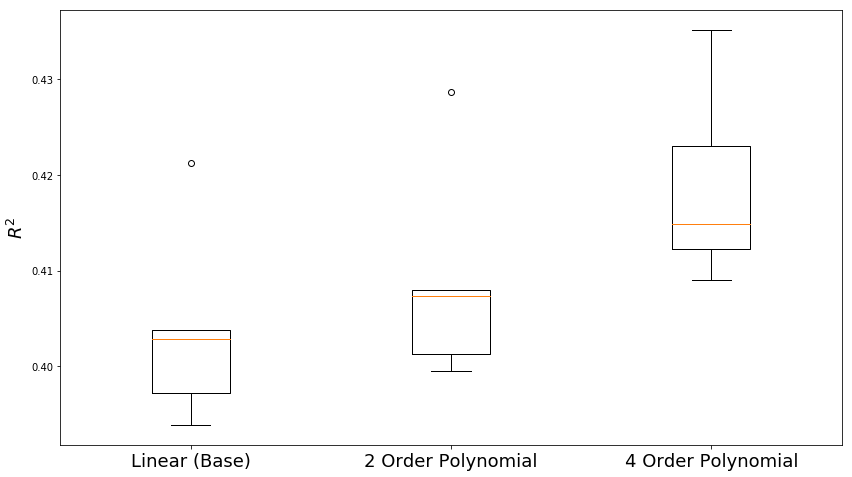

In [220]:
plt.figure(figsize=(14,8))
plt.boxplot([x_kfold_scores, poly2_kfold_scores, poly4_kfold_scores])
plt.ylabel(r"$R^2$", fontsize=18)
plt.xticks(range(1,4), ['Linear (Base)', '2 Order Polynomial', '4 Order Polynomial'], fontsize=18)
plt.show()

#### 3.9 Evaluate each of the model alternatives on the  test set.  How do the results compare with the results from cross-validation?

In [221]:
poly2_train, poly2_test = get_poly_dataset(X_train, X_test, 2)
poly4_train, poly4_test = get_poly_dataset(X_train, X_test, 4)

In [222]:
base_model = LinearRegression().fit(X_train, y_train)
poly2_model = LinearRegression().fit(poly2_train, y_train)
poly4_model = LinearRegression().fit(poly4_train, y_train)

In [223]:
print("R-squared for Base Model on Test: ", base_model.score(X_test, y_test))
print("R-squared for 2 Degree Polynomial Features Model on Test: ", poly2_model.score(poly2_test, y_test))
print("R-squared for 4 Degree Polynomial Features Model on Test: ", poly4_model.score(poly4_test, y_test))

R-squared for Base Model on Test:  0.40638554757102285
R-squared for 2 Degree Polynomial Features Model on Test:  0.41076037422804523
R-squared for 4 Degree Polynomial Features Model on Test:  0.42027912762252395


The models performed similarly on the test set as they did on the CV validation sets and on the training set.  The addition of polynomial features seems to have given us a sliver of additional predictive power without the issues of overfitting that we were initially concerned about.

#### **Note**

If we use our no-shuffle 5-fold cross validation strategy from Question 2 for model selection, will we make the same choice?  We have leeway here since we don't need to generate error bars for the $R^2$ scores that our models generated on the full training and test set, so even if we scores in a different range we'll be ok as long as we pick models consistent with those we selected with the shuffle 5-fold cross validation strategy.  Let's see what happens.

In [236]:
k_fold_ns = KFold(n_splits=5)

x_kfold_scores_ns = []
poly2_kfold_scores_ns = []
poly4_kfold_scores_ns = []

for k, (train_index, test_index) in enumerate(k_fold_ns.split(X_train, y_train)):
    # Create k-th Train & Test DataFrames
    X_kfold_train_ns = pd.DataFrame(X_train.values[train_index], columns=X_train.columns)  
    X_kfold_test_ns =  pd.DataFrame(X_train.values[test_index], columns=X_train.columns)
    
    y_kfold_train_ns, y_kfold_test_ns = y_train[train_index], y_train[test_index]
    
    # Create 2-nd and 4-th degree polynomial feature design matrices
    poly2_kfold_train_ns, poly2_kfold_test_ns = get_poly_dataset(X_kfold_train_ns, X_kfold_test_ns, 2)
    poly4_kfold_train_ns, poly4_kfold_test_ns = get_poly_dataset(X_kfold_train_ns, X_kfold_test_ns, 4)
    
    # Train
    kfold_ns = LinearRegression().fit(X_kfold_train_ns, y_kfold_train_ns)
    poly2_ns = LinearRegression().fit(poly2_kfold_train_ns, y_kfold_train_ns)
    poly4_ns = LinearRegression().fit(poly4_kfold_train_ns, y_kfold_train_ns)
    
    # Score
    x_kfold_scores_ns.append(kfold_ns.score(X_kfold_test_ns, y_kfold_test_ns))
    poly2_kfold_scores_ns.append(poly2_ns.score(poly2_kfold_test_ns, y_kfold_test_ns))
    poly4_kfold_scores_ns.append(poly4_ns.score(poly4_kfold_test_ns, y_kfold_test_ns))

In [237]:
all_kfold_scores_ns = np.array([x_kfold_scores_ns, poly2_kfold_scores_ns, poly4_kfold_scores_ns])

In [238]:
print("Model 1: Base Features")
print("Mean: ", all_kfold_scores_ns.mean(axis=1)[0])
print("Std. Dev:", all_kfold_scores_ns.std(axis=1)[0])

Model 1: Base Features
Mean:  0.2579944364362185
Std. Dev: 0.09220055096227732


In [239]:
print("Model 2:  Base Features plus polynomial features to order 2")
print("Mean: ", np.mean(poly2_kfold_scores_ns))
print("Std. Dev:", np.std(poly2_kfold_scores_ns))

Model 2:  Base Features plus polynomial features to order 2
Mean:  0.2632587511694263
Std. Dev: 0.07670352483743803


In [240]:
print("Model 3:  Base Features plus polynomial features to order 4")
print("Mean: ", np.mean(poly4_kfold_scores_ns))
print("Std. Dev:", np.std(poly4_kfold_scores_ns))

Model 3:  Base Features plus polynomial features to order 4
Mean:  0.26727805322296777
Std. Dev: 0.09109366555046872


As conjectured -- even with the difference in model performance on the 5-fold CV without shuffling validation sets, the relative model performance is the same as in the case where we shuffled our data before performing the cross-validation and we end up selecting the same model (Polynomial Features up to order 4).  Does visualization bear out these results? 

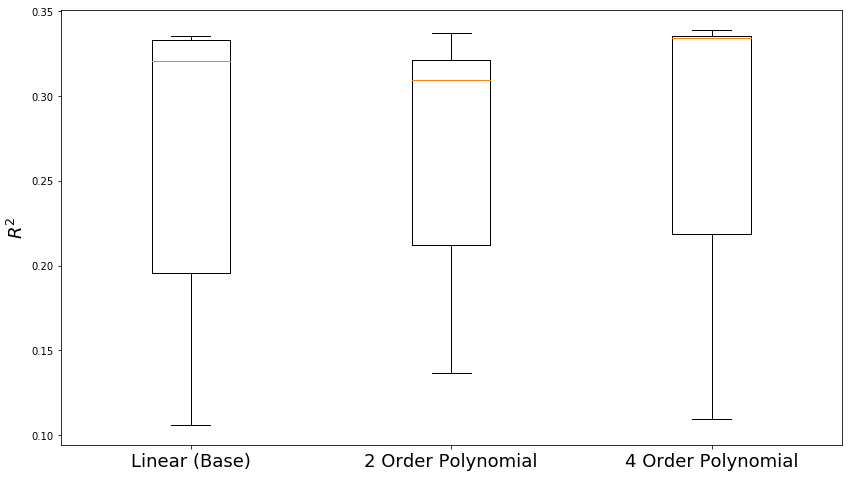

In [241]:
plt.figure(figsize=(14,8))
plt.boxplot([x_kfold_scores_ns, poly2_kfold_scores_ns, poly4_kfold_scores_ns])
plt.ylabel(r"$R^2$", fontsize=18)
plt.xticks(range(1,4), ['Linear (Base)', '2 Order Polynomial', '4 Order Polynomial'], fontsize=18)
plt.show()

Yes it does. As we saw above performance of the models on the test set is significantly better than on the CV validation sets, but the relative performance between the models is the same.  So while shuffling (based on our understanding of our data) seems like the best CV strategy in this case (as opposed to what we observed in Question 2) CV without shuffling would still lead you to the same choices for model selection.  In any case the takeaway is that your CV strategy is influenced by your data, and you shouldn't use a CV strategy without regard to the best approach for your data and without awareness of the ramnifications of how your CV strategy may affect the resulting models (in model selection).